In [1]:
# Purpose: Preparing the perturbation forcing for the basin-wide experiments, 
#          i.e. only forcing the Pacific Ocean, the Atlantic Ocean or the 
#          Indian Ocean
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
#     Maurice F. Huguenin, m.huguenin-virchaux@unsw.edu.au, 17. 09. 2020      #                                                
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #

# % preamble ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
save = '/home/561/mv7494/ENSOAnt_figures/'

import xarray as xr # for working with labelled multi-dimensional arrays                                                                
import numpy as np # for numerical operations                                                           
import cmocean as cm
from datetime import datetime # package for printing time in plot                                       
import string # for subplot annotation                                                                  
import matplotlib.pyplot as plt # for matlab-like plotting                                              
import cartopy.crs as ccrs # for maps                                                                   
import os.path # to check if file exists
from matplotlib import gridspec
import cartopy.mpl.ticker as cticker
import string # for subplot annotation
import cartopy.mpl.ticker as cticker
from matplotlib import ticker

import cartopy.feature as cfeature

import nc_time_axis
import cftime

# for displaying multiple output in one cell
from IPython.display import display as dp

# colours                                                                                               
ned_blue = [.12,.27,.54] # blue colour from the Dutch flag                                              
ned_red  = [.68,.10,.15] # red  "    "    "    "    "    "
myblue = [.19, .21, .58]
rotblau = [[0.4 , 0.  , 0.12], [0.47, 0.02, 0.13], [0.62, 0.07, 0.16], [0.66, 0.16, 0.2],
           [0.8 , 0.3 , 0.27], [0.87, 0.44, 0.35], [0.93, 0.58, 0.45], [0.96, 0.7 , 0.58], 
           [0.98, 0.8 , 0.71], [0.98, 0.94, 0.92], [0.93, 0.95, 0.96], [0.85, 0.91, 0.95],
           [0.76, 0.87, 0.93], [0.64, 0.8 , 0.89], [0.49, 0.72, 0.84], [0.34, 0.62, 0.79], 
           [0.23, 0.53, 0.74], [0.16, 0.44, 0.7] , [0.1 ,0.35, 0.6], [0.05, 0.24, 0.45], [0.02, 0.19, 0.38]]

from dask.distributed import Client
client = Client(n_workers=16)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 16
Total threads: 16,Total memory: 250.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35083,Workers: 16
Dashboard: /proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 250.00 GiB
Comm: tcp://127.0.0.1:34533,Total threads: 1
Dashboard: /proxy/39539/status,Memory: 15.62 GiB
Nanny: tcp://127.0.0.1:41085,


### All forcing fields in the Robinson (IPCC) projection

Plotting spatial maps for El Niño


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1714: UserWarning: The following kwargs were not used by contour: 'cmp'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1714: UserWarning: The following kwargs were not used by contour: 'cmp'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)


Plotting spatial maps for La Niña
CPU times: user 2min 57s, sys: 28.8 s, total: 3min 25s
Wall time: 2min 52s


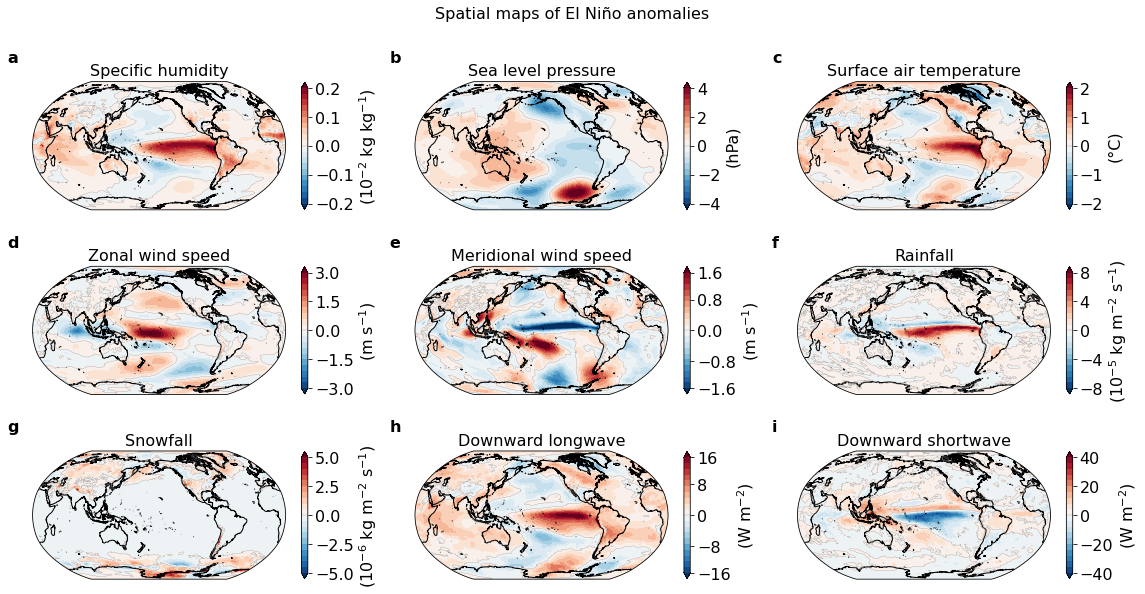

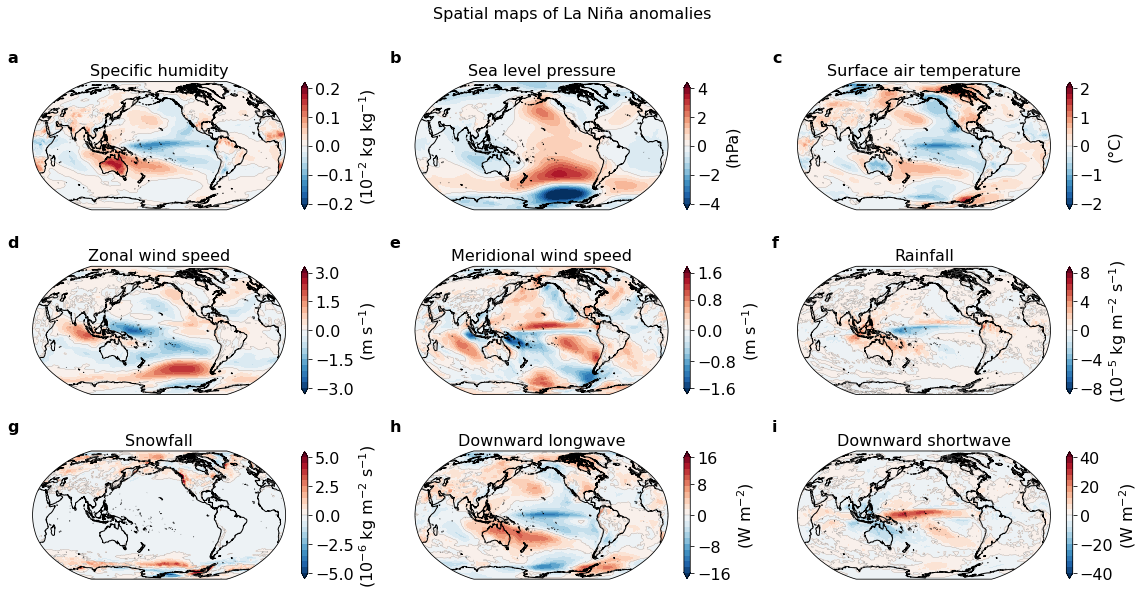

In [2]:
%%time
def fancy_plot(axes_nr):
    axes_nr.coastlines(resolution = '50m') # add coast lines
    lon_formatter = cticker.LongitudeFormatter();
    lat_formatter = cticker.LatitudeFormatter()
    axes_nr.xaxis.set_major_formatter(lon_formatter) # set format of x-axis
    axes_nr.yaxis.set_major_formatter(lat_formatter) # "       "       "
    axes_nr.xaxis.label.set_visible(False) # no axis labels
    axes_nr.yaxis.label.set_visible(False)
    axes_nr.tick_params(axis='both', which='major', labelsize=16) # fontsize of lon/lat labels
    
base = '/g/data/e14/mv7494/JRA55-do-1-3/spatial_patterns/sp_mean_anoms_'
exp = ['EN', 'LN']; exp_long = ['El Niño', 'La Niña']

vars = ['huss_10m', 'psl', 'tas_10m', 'uas_10m', 'vas_10m', 'prrn', 'prsn', 'rlds', 'rsds', 'friver']

var_titles = ['Specific humidity', 'Sea level pressure', 'Surface air temperature', 'Zonal wind speed', 'Meridional wind speed',
             'Rainfall', 'Snowfall', 'Downward longwave', 'Downward shortwave', 'River runoff']
var_units = ['10$^{-2}$ kg kg$^{-1}$', 'hPa', '°C', 'm s$^{-1}$', 'm s$^{-1}$',
             '10$^{-5}$ kg m$^{-2}$ s$^{-1}$', '10$^{-6}$ kg m$^{-2}$ s$^{-1}$', 'W m$^{-2}$', 'W m$^{-2}$', 'kg m$^{-2}$ s$^{-1}$']

for f in range(2):
    # initialise figure     ( l, h) -> length and height of plot 
    fig = plt.figure(figsize=(16,9),tight_layout=True,facecolor='w',edgecolor='k') 

    print('Plotting spatial maps for '+exp_long[f])

    for v in range(9): # loop through all variables
        # load in the data
        if v <= 8: field = xr.open_dataset(base + exp[f] + '.nc')[vars[v]]
        else: field = xr.open_dataset(base + exp[f] + '_friver.nc')[vars[v]]
        
        if v == 0: scale = 1e2;  ticks = np.linspace(-.2,.2,21)   # huss
        if v == 1: scale = 1e-2; ticks = np.linspace(-4,4,21)     # psl 
        if v == 2: scale = 1;    ticks = np.linspace(-2,2,21)     # tas
        if v == 3: scale = 1;    ticks = np.linspace(-3,3,21)     # uas
        if v == 4: scale = 1;    ticks = np.linspace(-1.5,1.5,21) # vas
        if v == 5: scale = 1e5;  ticks = np.linspace(-8,8,21)     # prrn 
        if v == 6: scale = 1e6;  ticks = np.linspace(-5,5,21)     # prsn
        if v == 7: scale = 1;    ticks = np.linspace(-15,15,21)   # rlds
        if v == 8: scale = 1;    ticks = np.linspace(-40,40,21)   # rsds
        # if v == 9: scale = 1e-4; ticks = np.linspace(-5,5,21)   # friver   
        
        ax1 = plt.subplot(3,3,v+1, projection=ccrs.Robinson(central_longitude=200)) # longitude starting at Cape Agulhas (20°E)
        # ------------------------------------ #
        p1  = (field*scale).plot.contourf(ax=ax1, levels = ticks, cmp='RdBu_r',add_colorbar=False,extend='both',transform=ccrs.PlateCarree())
        p11 = (field*scale).plot.contour(levels = [0], linewidths=.25, cmap='grey', transform=ccrs.PlateCarree())
        # ------------------------------------ #

        # if v == 0: # add tick labels for °N and °S                                                    # transparent color
        #     grd = ax1.gridlines(draw_labels=True, xlocs=[22,180,0], ylocs=[-80,-40,0,40,80], color='#FF000000')
        #     grd.top_labels = False
        #     grd.xlabel_style = {'size': 16}; grd.ylabel_style = {'size': 16}

        # add colour bar   
        cb = plt.colorbar(p1, shrink=.55, orientation='vertical'); 
        cb.set_label(label='('+var_units[v]+')', size=16)
        cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=4)
        cb.locator = tick_locator;cb.update_ticks() 
        cb.add_lines(p11) # add contours to colour bar

        plt.title(var_titles[v], fontsize=16)
        fancy_plot(ax1)
        ax1.text(-.1, 1.15,string.ascii_lowercase[v], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
        
        if v < 6: ax1.set_xticklabels([])  # remove unnecessary tick labels
        if v in [1,2,4,5,7,8]: ax1.set_yticklabels([])
        
    # fig.patch.set_linewidth(2); fig.patch.set_edgecolor('cornflowerblue') # border around the full plot to see the empty white space I have
    plt.suptitle('Spatial maps of '+exp_long[f]+' anomalies', fontsize=16)
    
    # --- saving as 300 dpi .PNG image in specified folder --------------------- #
    plt.savefig(save + 'all_forcing_fields_spatial_maps_'+exp[f]+'Full_Robinson', 
                dpi=300, facecolor='w',                                          #
                edgecolor='w', orientation='landscape',                          #
                format=None, transparent=False, bbox_inches='tight',             #
                pad_inches=0.1, metadata=None)                                   #
    # --- end of script -------------------------------------------------------- # 
# Wall time: 3min 13s

### Next, for the PhD thesis I also need the Nino3.4 time series and regression maps of all forcing fields

CPU times: user 55 s, sys: 4.1 s, total: 59.1 s
Wall time: 58.8 s


Text(0.5, 1.0, 'N34 index (°C)')

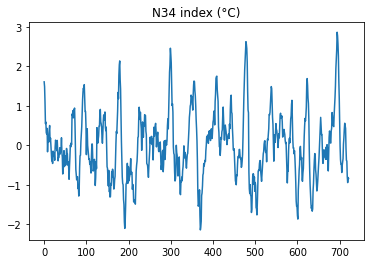

In [3]:
%%time
# ------------------------------------------------------------------------------------------------------------ #
forcing = '1-3' # 1-4-0                                                                                        #
period = ['1958','2018'] # which period to consider for anomaly calculation                                    #
version = 'v20180412' #'v20190429'                                                                             #
short = 'gn' # 'gr'                                                                                            #
lat_N34 = [150, 169] # 5°S-5°N                                                                                 #
lon_N34 = [339, 428] # 160°W-120°W                                                                             #
# ------------------------------------------------------------------------------------------------------------ #
base = '/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-' + forcing + '/'
out = '/g/data/e14/mv7494/JRA55-do-'+forcing+'/'

f11 = out+'monthly_mean/JRA55-do-'+forcing+'_'; f22 = '_monthly_mean_'+period[0]+'-'+period[1]+'.nc'

ts = xr.open_dataset(f11 + 'ts' + f22).ts.groupby('time.month') - (
    xr.open_dataset(f11 + 'ts' + f22).ts.groupby('time.month').mean('time')) # load in monthly mean surface temperature & remove climatology to calculate anomalies

N34_JRA = ts[:, lat_N34[0]:lat_N34[1], lon_N34[0]:lon_N34[1]].mean(['lat','lon']).load() # select N34 index and load into memory
plt.plot(N34_JRA); plt.title('N34 index (°C)')
# Wall time: 26.5 s

<timed exec>:31: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error in 3.6


CPU times: user 791 ms, sys: 78.8 ms, total: 870 ms
Wall time: 759 ms


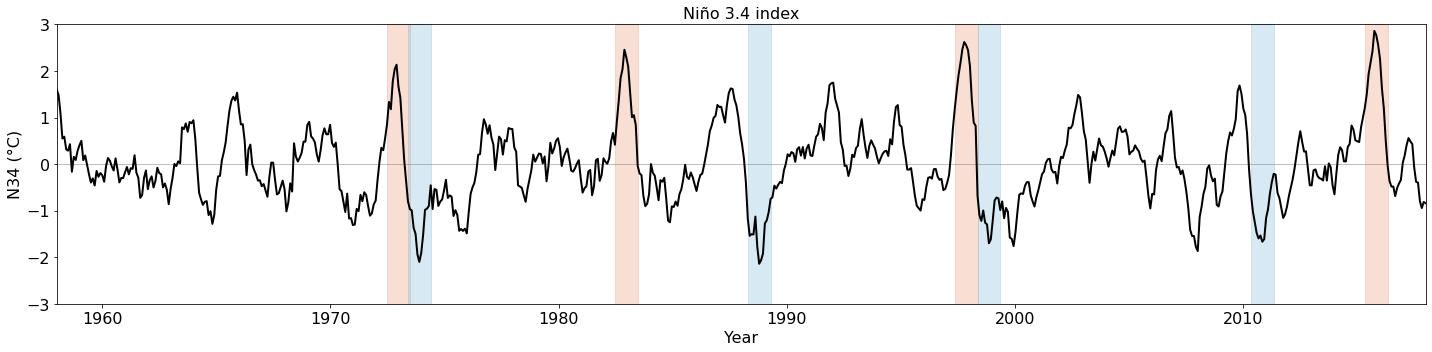

In [4]:
%%time
time = np.linspace(1958,2018,len(N34_JRA))

fig, ax1 = plt.subplots(figsize=(20,5),tight_layout=True,facecolor='w',edgecolor='k')
gs = gridspec.GridSpec(1,1); 

# ---------------------------------------------------------------------------------------------------------------------------------------------------------- #
ax1 = plt.subplot(gs[0,0])
plt.axhline(0, linewidth=.5, c='grey')
plt.plot(time, N34_JRA, c = 'k', linewidth=2, label='N3.4')
plt.xticks(fontsize=16); plt.yticks(fontsize=16)
plt.xlabel('Year', fontsize=16); plt.ylabel('N34 (°C)', fontsize=16)
plt.ylim([-3,3])

# colour the periods of strong EN & LN
EN_periods = [168,192,288,312,467,491,683,707]; LN_periods = [168,216,347,395,468,516,612,660]
# first doing the shading manually so that I can have figure labels
ax1.axvspan(time[EN_periods[0]+6], time[EN_periods[0]+18], color=rotblau[6], alpha=.3, label='El Niño event')
ax1.axvspan(time[LN_periods[0]+6+11], time[LN_periods[0]+18+11], color=rotblau[14], alpha=.3, label='La Niña event')
for f in [2,4,6]:
    ax1.axvspan(time[EN_periods[f]+6], time[EN_periods[f]+18], color=rotblau[6], alpha=.3)
    ax1.axvspan(time[LN_periods[f]+6+11], time[LN_periods[f]+18+11], color=rotblau[14], alpha=.3)

plt.xlim([1958,2018]);

plt.title('Niño 3.4 index', fontsize=16) # title
ax1.tick_params(axis='y', labelcolor='k'); plt.xticks(fontsize=16); plt.yticks(fontsize=16) # big ticks
# ax1.text(0, 1.15,string.ascii_lowercase[0], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top


# --- saving as 300 dpi .PNG image in specified folder --------------------------------------- #
plt.savefig(save + 'Nino34_index_JRA55-do', dpi=300, facecolor='w',           #
            edgecolor='w', orientation='landscape', papertype=None,                            #
            format=None, transparent=False, bbox_inches='tight',                               #
            pad_inches=0.1, metadata=None)                                                     #
# --- end of script -------------------------------------------------------------------------- #
# Wall time: 1.98 s

### All forcing fields in the Robinson (IPCC) projection, but for the N34 regression patterns now

Plotting spatial maps for full N34 regression


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1714: UserWarning: The following kwargs were not used by contour: 'cmp'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1714: UserWarning: The following kwargs were not used by contour: 'cmp'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1714: UserWarning: The following kwargs were not used by contour: 'cmp'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1714: UserWarning: The following kwargs were not used by contour: 'cmp'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/g/data/hh5/public/apps/mini

CPU times: user 1min 14s, sys: 11.8 s, total: 1min 26s
Wall time: 1min 11s


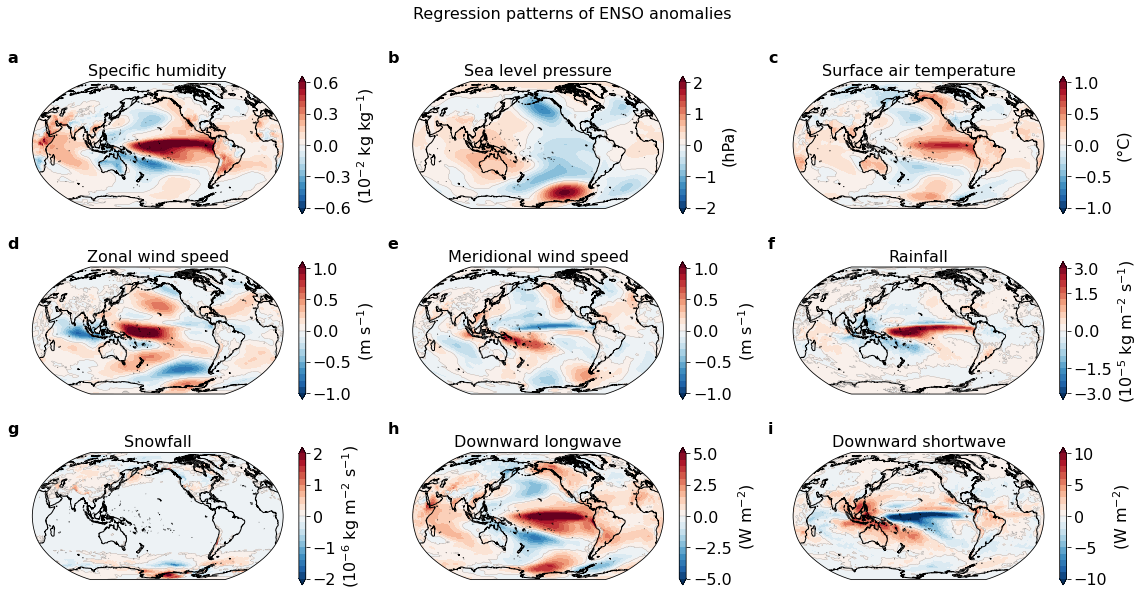

In [5]:
%%time
def fancy_plot(axes_nr):
    axes_nr.coastlines(resolution = '50m') # add coast lines
    axes_nr.tick_params(axis='both', which='major', labelsize=16) # fontsize of lon/lat labels

base = '/g/data/e14/mv7494/JRA55-do-1-3/spatial_patterns/sp_'
exp = ['mean_anoms_EN', 'mean_anoms_LN', 'N34_full_time_series']
exp_long = ['El Niño', 'La Niña', 'full N34 regression']

vars = ['huss_10m', 'psl', 'tas_10m', 'uas_10m', 'vas_10m', 'prrn', 'prsn', 'rlds', 'rsds', 'friver']

var_titles = ['Specific humidity', 'Sea level pressure', 'Surface air temperature', 'Zonal wind speed', 'Meridional wind speed',
             'Rainfall', 'Snowfall', 'Downward longwave', 'Downward shortwave', 'River runoff']
var_units = ['10$^{-2}$ kg kg$^{-1}$', 'hPa', '°C', 'm s$^{-1}$', 'm s$^{-1}$',
             '10$^{-5}$ kg m$^{-2}$ s$^{-1}$', '10$^{-6}$ kg m$^{-2}$ s$^{-1}$', 'W m$^{-2}$', 'W m$^{-2}$', 'kg m$^{-2}$ s$^{-1}$']

for f in [2]:
    # initialise figure     ( l, h) -> length and height of plot 
    fig = plt.figure(figsize=(16,9),tight_layout=True,facecolor='w',edgecolor='k') 

    print('Plotting spatial maps for '+exp_long[f])

    for v in range(9): # loop through all variables
        # load in the data
        if v <= 8: field = xr.open_dataset(base + exp[f] + '.nc')[vars[v]]
        else: field = xr.open_dataset(base + exp[f] + '_friver.nc')[vars[v]]
        
        field = field / np.std(N34_JRA) # divide by the standard deviation of the N34 index so that I get units of °C*X/°C 
                                        # I forgot this part before saving the file as .nc previously
        if v == 0: scale = 1e3;  ticks = np.linspace(-.6,.6,21)   # huss
        if v == 1: scale = 1e-2; ticks = np.linspace(-2,2,21)     # psl 
        if v == 2: scale = 1;    ticks = np.linspace(-1,1,21)     # tas
        if v == 3: scale = 1;    ticks = np.linspace(-1,1,21)     # uas
        if v == 4: scale = 1;    ticks = np.linspace(-1,1,21) # vas
        if v == 5: scale = 1e5;  ticks = np.linspace(-2.5,2.5,21)     # prrn 
        if v == 6: scale = 1e6;  ticks = np.linspace(-2,2,21)     # prsn
        if v == 7: scale = 1;    ticks = np.linspace(-5,5,21)   # rlds
        if v == 8: scale = 1;    ticks = np.linspace(-10,10,21)   # rsds
        # if v == 9: scale = 1e-4; ticks = np.linspace(-5,5,21)   # friver   
        

        ax1 = plt.subplot(3,3,v+1, projection=ccrs.Robinson(central_longitude=200)) # longitude starting at Cape Agulhas (20°E)
        # ------------------------------------ #
        p1  = (field*scale).plot.contourf(ax=ax1, levels = ticks, cmp='RdBu_r',add_colorbar=False,extend='both',transform=ccrs.PlateCarree())
        p11 = (field*scale).plot.contour(levels = [0], linewidths=.25, cmap='grey', transform=ccrs.PlateCarree())
        # ------------------------------------ #
        
        # add colour bar   
        cb = plt.colorbar(p1, shrink=.6, orientation='vertical'); 
        cb.set_label(label='('+var_units[v]+')', size=16)
        cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=4)
        cb.locator = tick_locator;cb.update_ticks() 
        cb.add_lines(p11) # add contours to colour bar

        plt.title(var_titles[v], fontsize=16)
        fancy_plot(ax1)
        ax1.text(-.1, 1.15,string.ascii_lowercase[v], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
        
        if v < 6: ax1.set_xticklabels([])  # remove unnecessary tick labels
        if v in [1,2,4,5,7,8]: ax1.set_yticklabels([])
        
    # fig.patch.set_linewidth(2); fig.patch.set_edgecolor('cornflowerblue') # border around the full plot to see the empty white space I have
    plt.suptitle('Regression patterns of ENSO anomalies', fontsize=16)
    
    # --- saving as 300 dpi .PNG image in specified folder --------------------- #
    plt.savefig(save + 'all_forcing_fields_spatial_maps_'+exp[f]+'Full_Robinson', 
                dpi=300, facecolor='w',                                          #
                edgecolor='w', orientation='landscape',                          #
                format=None, transparent=False, bbox_inches='tight',             #
                pad_inches=0.1, metadata=None)                                   #
    # --- end of script -------------------------------------------------------- # 
# Wall time: 1min 17s

### ... and now combined Nino 3.4 index and only the most important fields

CPU times: user 53.1 s, sys: 3.69 s, total: 56.8 s
Wall time: 50 s


Text(0.5, 1.0, "<xarray.DataArray 'ts' ()>\narray(0.8415457)")

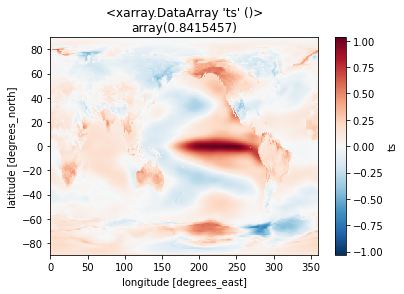

In [6]:
%%time
# calculating the Niño3.4 regression SST pattern
out = '/g/data/e14/mv7494/JRA55-do-1-3/'
f11 = out+'monthly_mean/JRA55-do-'+forcing+'_'
f22 = '_monthly_mean_'+period[0]+'-'+period[1]+'.nc'
# remove monthly mean to calculate anomalies
anom = xr.open_dataset(f11 + 'ts' + f22).ts.groupby('time.month') - (xr.open_dataset(f11 + 'ts' + f22).ts.groupby('time.month').mean('time'))

SST_map = ((N34_JRA * anom)/np.std(N34_JRA)).mean('time').load()
SST_map.plot()
N34_value = SST_map.isel(lon = slice(339,428)).isel(lat = slice(150,169)).mean(['lat','lon']).load()
plt.title(str(N34_value))
# Wall time: 

In [7]:
# loading in the main regression files from above for SLP, u and v winds
psl = xr.open_dataset('/g/data/e14/mv7494/JRA55-do-1-3/spatial_patterns/sp_N34_full_time_series.nc').psl            /np.std(N34_JRA)
uas_10m = xr.open_dataset('/g/data/e14/mv7494/JRA55-do-1-3/spatial_patterns/sp_N34_full_time_series.nc').uas_10m    /np.std(N34_JRA)
vas_10m = xr.open_dataset('/g/data/e14/mv7494/JRA55-do-1-3/spatial_patterns/sp_N34_full_time_series.nc').vas_10m    /np.std(N34_JRA) # I forgot this step previously during the regression...this is to
                                                                                                                                     # get units of °C * X /°C = X

### Plotting routine

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1714: UserWarning: The following kwargs were not used by contour: 'cmp'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
<timed exec>:131: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error in 3.6


CPU times: user 18.5 s, sys: 2.93 s, total: 21.5 s
Wall time: 18.5 s


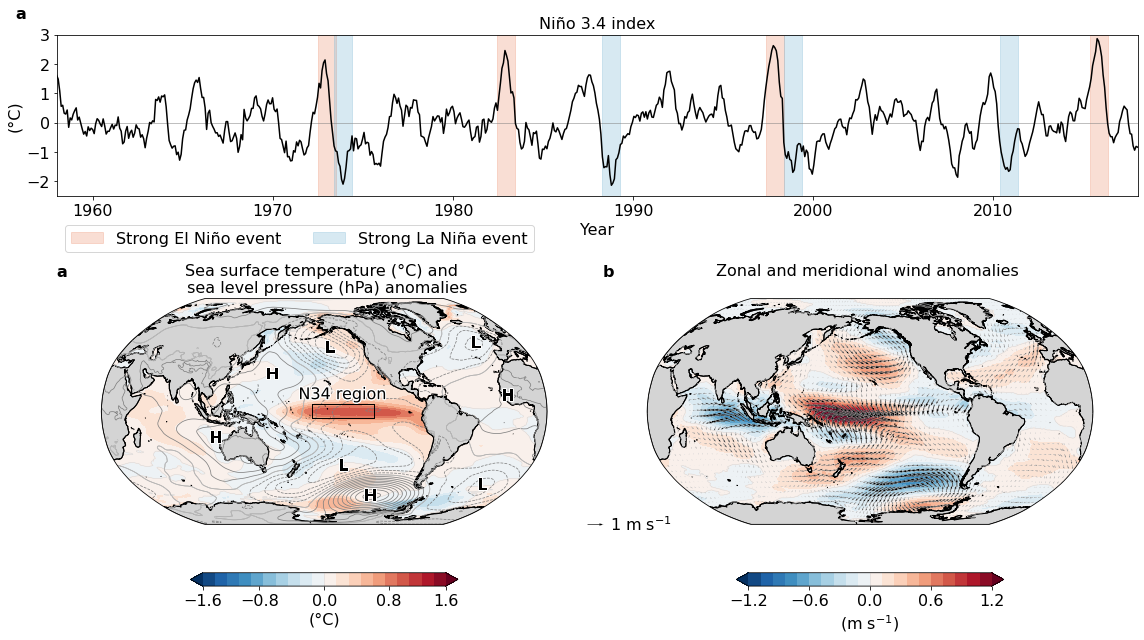

In [8]:
%%time
import matplotlib.patheffects as PathEffects
from wrf import to_np # conversion to arrays required for arrows on maps    

fig = plt.figure(figsize=(16,9),tight_layout=True,facecolor='w',edgecolor='k'); 
gs = gridspec.GridSpec(2,2, height_ratios=[.5,1]) 
ax1 = plt.subplot(gs[0,:]) # long first panel

time = np.linspace(1958,2018,len(N34_JRA)) # I cannot use the .time attribute from the xarray array as using it does not work with ax1.axvspan()

ax1.axhline(0, linewidth=.5, c='grey')

# colour the periods of strong EN & LN
EN_periods = [168,192,288,312,467,491,683,707]; LN_periods = [168,216,347,395,468,516,612,660]
# first doing the shading manually so that I can have figure labels
ax1.axvspan(time[EN_periods[0]+6], time[EN_periods[0]+18], color=rotblau[6], alpha=.3, label='Strong El Niño event')
ax1.axvspan(time[LN_periods[0]+6+11], time[LN_periods[0]+18+11], color=rotblau[14], alpha=.3, label='Strong La Niña event')
for f in [2,4,6]:
    ax1.axvspan(time[EN_periods[f]+6], time[EN_periods[f]+18], color=rotblau[6], alpha=.3)
    ax1.axvspan(time[LN_periods[f]+6+11], time[LN_periods[f]+18+11], color=rotblau[14], alpha=.3)

    
# -------------------------------------------------------------------------------------------- #
plt.plot(time, N34_JRA, c='k', linewidth=1.5) # plot the data
# -------------------------------------------------------------------------------------------- #

plt.title('Niño 3.4 index', fontsize=16)

plt.legend(ncol=2,fontsize=16, bbox_to_anchor=(0, -.4), loc='lower left') # figure legend outside
plt.xlim([1958,2018]); plt.ylim([-2.5,3])
plt.ylabel('(°C)', fontsize=16); plt.xlabel('Year', fontsize=16); plt.xticks(fontsize=16); plt.yticks(fontsize=16)

ax1.text(-.038, 1.1,string.ascii_lowercase[0], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top

# second and third panels with SST, SLP, and winds ---------------------------------------------- #
for f in range(2):
    if f == 0: 
        panel = gs[1,0]; 
        data1 = SST_map; ticks1 = np.linspace(-1.5,1.5,21)
        data2 = psl / 100; ticks2 = np.linspace(-2,2,21)
        title_str = 'Sea surface temperature (°C) and \n sea level pressure (hPa) anomalies'
    if f == 1: 
        panel = gs[1,1] 
        data1 = uas_10m; ticks1 = np.linspace(-1.2,1.2,21)
        data2 = vas_10m
        title_str = 'Zonal and meridional wind anomalies \n'
    
    
    
    ax1 = plt.subplot(panel, projection=ccrs.Robinson(central_longitude=200)) # longitude starting at Cape Agulhas (20°E)
    def fancy_plot(axes_nr):
        axes_nr.coastlines(resolution = '50m', linewidth=1) # add coast lines
        axes_nr.add_feature(cfeature.LAND, edgecolor = 'black', facecolor = [.83, .83, .83], zorder = 1)
        axes_nr.tick_params(axis='both', which='major', labelsize=16) # fontsize of lon/lat labels
    
    # ---------------------------------------------------------------------------------------------------------------------------------------------------- #
    p1  = data1.plot.contourf(ax=ax1, levels = ticks1, cmp='RdBu_r',add_colorbar=False,extend='both',transform=ccrs.PlateCarree())
    p11 = data1.plot.contour(levels = [0], linewidths=.5, cmap='#d4d4d4', transform=ccrs.PlateCarree())
    
    if f == 0:
        p2  = data2.plot.contour(ax=ax1, levels = ticks2, colors='grey',linewidths=.75, transform=ccrs.PlateCarree())
        p22 = data2.plot.contour(levels = [0], linewidths=.5, cmap='#d4d4d4', transform=ccrs.PlateCarree())  
        
        peak_anom_coords = [   247.5, -61.497532, # ASL positive anomaly
                            351., -53.07323, # South Atlantic negative anomaly
                           339.75, 48.580264, # North Atlantic negative anomaly
                           205.3125, 45.210538, # North Pacific negative anomaly
                           111.375, -19.375951, # Darwin High anomaly
                           216.5625, -39.032705,# Low anomaly over the South Pacific
                           156.9375, 26.11541, # high over the subtropical North Pacific    
                           349.3125, 10.951625]   # high over West Africa 
        txt = plt.text(peak_anom_coords[0], peak_anom_coords[1], 'H', c='k', fontsize=16, fontweight='bold', transform=ccrs.PlateCarree(), ha='center', va='center')
        txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')]) 
        txt = plt.text(peak_anom_coords[2], peak_anom_coords[3], 'L', c='k', fontsize=16, fontweight='bold', transform=ccrs.PlateCarree(), ha='center', va='center')
        txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')]) 
        txt = plt.text(peak_anom_coords[4], peak_anom_coords[5], 'L', c='k', fontsize=16, fontweight='bold', transform=ccrs.PlateCarree(), ha='center', va='center')
        txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')]) 
        txt = plt.text(peak_anom_coords[6], peak_anom_coords[7], 'L', c='k', fontsize=16, fontweight='bold', transform=ccrs.PlateCarree(), ha='center', va='center')
        txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')]) 
        txt = plt.text(peak_anom_coords[8], peak_anom_coords[9], 'H', c='k', fontsize=16, fontweight='bold', transform=ccrs.PlateCarree(), ha='center', va='center')
        txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')]) 
        txt = plt.text(peak_anom_coords[10], peak_anom_coords[11], 'L', c='k', fontsize=16, fontweight='bold', transform=ccrs.PlateCarree(), ha='center', va='center')
        txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')]) 
        txt = plt.text(peak_anom_coords[12], peak_anom_coords[13], 'H', c='k', fontsize=16, fontweight='bold', transform=ccrs.PlateCarree(), ha='center', va='center')
        txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')]) 
        txt = plt.text(peak_anom_coords[14], peak_anom_coords[15], 'H', c='k', fontsize=16, fontweight='bold', transform=ccrs.PlateCarree(), ha='center', va='center')
        txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')]) 
                                    
    if f == 1:
        skala = 30; niveau = [-12,-10,-8,-6,-4,-2,2,4,6,8,10,12]
        # adding 10 m wind data
        # specifics for the wind speed arrows
        X = data1.lon; Y = data1.lat
        U = data1; V = data2
        # Add the wind stress arrows, only plotting every 30th data point.
        Q = plt.quiver(to_np(X[::7]),   to_np(Y[::7]), 
                   to_np(U[::7, ::7]), to_np(V[::7, ::7]), 
                   scale=28, minshaft = 2, minlength=0.1, transform=ccrs.PlateCarree(), width=.002, linewidths=.2, edgecolor=('w')) 
                              # minshaft = select minimum sized arrow (i.e., only those larger than 2)

        # reference key on the map
                            # x0,   y0, scale
        qk = plt.quiverkey(Q, -.1, -0, 1, r'1 m s$^{-1}$', labelpos='E', fontproperties={'size':16}) 
    # ---------------------------------------------------------------------------------------------------------------------------------------------------- #

    # add colour bar   
    cb = plt.colorbar(p1, shrink=.5, orientation='horizontal'); 
    if f == 0: cb.set_label(label='(°C)', size=16)
    if f == 1: cb.set_label(label='(m s$^{-1}$)', size=16)
    cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=4)
    cb.locator = tick_locator;cb.update_ticks() 
    cb.add_lines(p11) # add contours to colour bar
    fancy_plot(ax1)

    # # drawing the N34 rectangle
    if f == 0:
        for r in range(4): # loop through the four sides of the rectangle
            if r == 0: lons = [-170,-120]; lats = [-5, -5] # bottom
            if r == 1: lons = [-170,-120]; lats = [5,   5] # top
            if r == 2: lons = [-170,-170]; lats = [-5,  5] # left
            if r == 3: lons = [-120,-120]; lats = [-5,  5] # right
            txt = plt.plot([lons[0],lons[1]], [lats[0], lats[1]], color = 'black', linewidth=1, transform=ccrs.PlateCarree(),)
            txt = plt.text(-145, 12, 'N34 region', 
                   verticalalignment='center',transform=ccrs.PlateCarree(), fontsize = 16, horizontalalignment='center') # include N34 value in plot
            txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')]) 

    plt.title(title_str, size=16)
    

    ax1.text(-.1, 1.1,string.ascii_lowercase[f], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
# --- saving as 300 dpi .PNG image in specified folder --------------------------------------- #
plt.savefig(save + 'Nino34_index_JRA55-do_and_main_spatial_patterns', dpi=300, facecolor='w',           #
            edgecolor='w', orientation='landscape', papertype=None,                            #
            format=None, transparent=False, bbox_inches='tight',                               #
            pad_inches=0.1, metadata=None)                                                     #
# --- end of script -------------------------------------------------------------------------- #
# Wall time: 10.5 s

### One panel with climatological winds

In [9]:
uas = xr.open_dataset('/g/data/e14/mv7494/JRA55-do-1-3/monthly_mean/JRA55-do-1-3_uas_monthly_mean_1958-2018.nc').uas.mean('time').load()
vas = xr.open_dataset('/g/data/e14/mv7494/JRA55-do-1-3/monthly_mean/JRA55-do-1-3_vas_monthly_mean_1958-2018.nc').vas.mean('time').load()

In [54]:
%%time
import cosima_cookbook as cc
session = cc.database.create_session()

# ---------------------------------------------------------------------------------- #
time      = [   2,   55]  # [  30, 1613] = 2012-12-01 to 2017-04-01 just like SOSE   #
depth     = [   0,   18]  # [  0,    47] = 0.5 m - 48.9 m                            #
sel_lat   = [   0,  950]  # [120,   263] = 76.03°S - 70.04°S                         #
# ---------------------------------------------------------------------------------- #
uas_snap = cc.querying.getvar(expt='01deg_jra55v140_iaf', variable='u', 
                                    session=session, frequency='1 daily',
                                    attrs={'cell_methods': 'time: mean'},
                                    start_time='1991-09-01 00:00:00', 
                                    end_time='1991-12-31 00:00:00', 
                                    chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'})[:, 0, sel_lat[0]:sel_lat[1], :]
vas_snap = cc.querying.getvar(expt='01deg_jra55v140_iaf', variable='v', 
                                    session=session, frequency='1 daily',
                                    attrs={'cell_methods': 'time: mean'},
                                    start_time='1991-09-01 00:00:00', 
                                    end_time='1991-12-31 00:00:00', 
                                    chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'})[:, 0, sel_lat[0]:sel_lat[1], :]
speed = (uas_snap*uas_snap+vas_snap*vas_snap)[57,:,:]
speed
# Wall time: 5.78 s

CPU times: user 437 ms, sys: 205 ms, total: 643 ms
Wall time: 649 ms


<xarray.DataArray (yu_ocean: 950, xu_ocean: 3600)>
dask.array<getitem, shape=(950, 3600), dtype=float32, chunksize=(950, 3600), chunktype=numpy.ndarray>
Coordinates:
  * xu_ocean  (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 -81.09 -81.05 -81.0 ... -28.45 -28.36 -28.28
    st_ocean  float64 0.5413
    time      datetime64[ns] 1991-09-27T12:00:00

Text(0.5, 0.98, 'Surface speed snapshot')

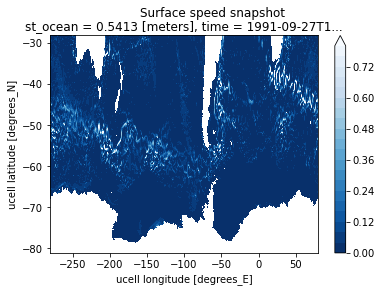

In [55]:
speed.plot(cmap='Blues_r', levels=np.linspace(0,.8,21))
plt.suptitle('Surface speed snapshot')



  fig.canvas.print_figure(bytes_io, **kw)



CPU times: user 2min 27s, sys: 19.1 s, total: 2min 46s
Wall time: 2min 45s


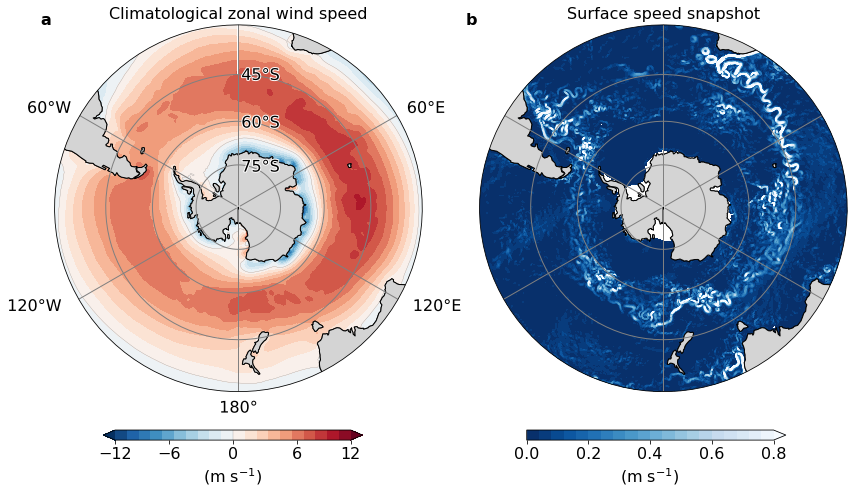

In [56]:
%%time
import matplotlib.path as mpath 
def fancy_plot(ax):
    ax.gridlines(color='grey', linewidth=1, alpha=1, # dots as grid lines
                  xlocs=range(-180, 180, 60), # longitude grid lines
                  ylocs= np.linspace(-45, -90, num=4)) # latitude grid lines
    ax.coastlines(); # add coast lines
    theta = np.linspace(0, 2*np.pi, 100); center, radius = [0.5, 0.5], .5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    # colour in land and coastlines
    ax.add_feature(cfeature.LAND, edgecolor = 'black', facecolor = [.83,.83,.83], zorder = 2)
    
# ------------------------------------------------------------------- #
# initialise figure
fig = plt.figure(figsize=(12,14),tight_layout=True,facecolor='w',edgecolor='k')
gs = gridspec.GridSpec(3, 2, width_ratios=[1,1], height_ratios=[.75,1,.75]) 
      
# ---------------------------- subplot 1 ---------------------------- #
for f in [3, 4]:
    if f in [3,4]:
        skala = 30; niveau = [-12,-10,-8,-6,-4,-2,2,4,6,8,10,12]
        if f in [3]:
            panel = gs[1,0]; 
            titel = 'Climatological zonal wind speed'; ticks = np.linspace(-11,11,21); farbe =  'RdBu_r'
        if f in [4]:
            panel = gs[1,1]; 
            titel = 'Surface speed snapshot'; ticks = np.linspace(0,.8,21); farbe = 'Blues_r'
            
        ax1 = plt.subplot(panel, projection=ccrs.SouthPolarStereo(central_longitude=0))
        ax1.set_extent([-180, 180, -90, -30], crs=ccrs.PlateCarree())
        
        # --------------------------------------------------------------------------------------------------------------------------- #
        if f == 3: 
            p1 = uas.plot.contourf(ax=ax1, levels=ticks, cmap=farbe, add_colorbar=False,extend='both',transform=ccrs.PlateCarree())
            p111 = uas.plot.contour(levels = [0], linewidths=.25, cmap='grey', transform=ccrs.PlateCarree())
        if f == 4:
            p2 = speed.plot.contourf(ax=ax1, levels=ticks, cmap=farbe, add_colorbar=False,extend='max',transform=ccrs.PlateCarree())
        # p1000 = field.plot.contour(levels = [1000], linewidths=2, cmap='k', transform=ccrs.PlateCarree()) # 1000 m isobath
        # --------------------------------------------------------------------------------------------------------------------------- #  
        fancy_plot(ax1)        
        
        

        # if f == 3: ax1.plot(151.2093, -33.8688, marker='X', color='red', markersize=8, transform=ccrs.PlateCarree()) # plot marker showing location of Sydney

        ax1.text(-.038, 1, string.ascii_lowercase[f-3], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
        

        if f in [3]:
            xlab =    [  1.01,    1.04,     .5,   -.055,  -.015,    .56,   .56,     .56] # x-position of labels
            ylab =    [   .76,     .22,  -.057,     .22,    .76,    .6,    .72,     .85] # y-position of labels
            txt_lab = ['60°E', '120°E', '180°', '120°W', '60°W', '75°S', '60°S', '45°S']

    
    
            # loop through the 7 labels and surround with white space for higher visibility
            for l in range(len(txt_lab)):
                ax1.text(xlab[l], ylab[l], txt_lab[l], horizontalalignment='center', transform=ax1.transAxes, 
                        fontsize=16).set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')]) 

#         if f in [3,4]:
#             # adding 10 m wind data
#             # specifics for the wind speed arrows
#             X = uas_10m.lon; Y = uas_10m.lat
#             U = uas_10m; V = vas_10m
#             # widths = np.linspace(-.0001, .0001, X.size)
#             # Add the wind stress arrows, only plotting every 30th data point.
#             # --------------------------------------------------------------------------------------------------------------------------- #
#             Q = plt.quiver(to_np(X[::7]),   to_np(Y[::7]), 
#                        to_np(U[::7, ::7]), to_np(V[::7, ::7]), 
#                        scale=skala, minshaft = 2, scale_units='height', transform=ccrs.PlateCarree(), width=.005, linewidths=.3, edgecolor=('w')) 
#                                   # minshaft = select minimum sized arrow (i.e., only those larger than 2)
#             # --------------------------------------------------------------------------------------------------------------------------- #

#             # reference key on the map
#                                 # x0,   y0, scale
#         if f == 3:
#             qk = plt.quiverkey(Q, 0, -.035, 1, r'1 m s$^{-1}$', labelpos='E', fontproperties={'size':16}) 

        if f in [3,4]:
            plt.title(titel, fontsize=16) # add title
            
        if f in [3]: # add colour bar 
            cax = fig.add_axes([.12, .27, .3, .01]) # x0, y0, width, height
            cb = plt.colorbar(p1, cax = cax, shrink=.5, orientation='horizontal'); 
            cb.set_label(label='(m s$^{-1}$)', size=16); cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=4)
            cb.locator = tick_locator;cb.update_ticks(); cb.add_lines(p111)  
        if f in [4]: # add colour bar 
            cax = fig.add_axes([.61, .27, .3, .01]) # x0, y0, width, height
            cb = plt.colorbar(p2, cax = cax, shrink=.5, orientation='horizontal'); 
            cb.set_label(label='(m s$^{-1}$)', size=16); cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=4)
            cb.locator = tick_locator;cb.update_ticks(); cb.add_lines(p111)  
                      
# --- saving as 300 dpi .PNG image in specified folder --------------------------------------- #
plt.savefig(save + 'Climatological_zonal_winds_SO_speed', dpi=300, facecolor='w',                    #
            edgecolor='w', orientation='landscape', papertype=None,                            #
            format=None, transparent=False, bbox_inches='tight',                               #
            pad_inches=0.1, metadata=None)                                                     #
# --- end of script -------------------------------------------------------------------------- #
# Wall time: 10.5 s

In [13]:
# ----------------------------------------------------------------------------------------------------------------------- #
#                                                   Notes down below                                                      #
# ----------------------------------------------------------------------------------------------------------------------- #